In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [4]:
# Activation functions
def sigmoid(Z):
  return 1 / (1 + np.exp(-Z))

def sigmoid_derivative(A):
  return A * (1 - A)

def relu(x):
  return np.maximum(0,x)

def relu_derivative(x):
  return (x > 0).astype(float)

def tanh(x):
  return np.tanh(x)

def tanh_derivative(x):
  return 1 - np.tanh(x)**2

def softmax(Z):
  expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))  # to prevent overflow
  return expZ / np.sum(expZ, axis=0, keepdims=True)

In [5]:
# Initialize parameters
def initialize_parameters(layer_sizes):
  parameters = {}
  num_of_layers = len(layer_sizes)

  for i in range(1, num_of_layers):
    parameters[f'W{i}'] = np.random.randn(layer_sizes[i], layer_sizes[i-1]) * np.sqrt(2 / layer_sizes[i-1])
    parameters[f'b{i}'] = np.zeros((layer_sizes[i], 1))
    parameters[f'gamma{i}'] = np.ones((layer_sizes[i], 1))  # Scale parameter for batch norm
    parameters[f'beta{i}'] = np.zeros((layer_sizes[i], 1))  # Shift parameter for batch norm

  return parameters

# Forward Propogation
def forward_propagation(X, parameters, activations, is_training=True, batch_norm_cache=None):
  A = X
  caches = []
  num_layers = len(activations)
  if batch_norm_cache is None:
    batch_norm_cache = {}

  for i in range(1, num_layers + 1):
    W = parameters[f'W{i}']
    b = parameters[f'b{i}']
    Z = np.dot(W,A) + b

    # Batch normalization
    if is_training:
      mu = np.mean(Z, axis=1, keepdims=True)
      var = np.var(Z, axis=1, keepdims=True)
      Z_norm = (Z - mu) / np.sqrt(var + 1e-8)
      Z_tilde = parameters[f'gamma{i}'] * Z_norm + parameters[f'beta{i}']
      batch_norm_cache[f'mu{i}'] = mu
      batch_norm_cache[f'var{i}'] = var
      batch_norm_cache[f'Z_norm{i}'] = Z_norm
    else:

      Z_norm = (Z - batch_norm_cache[f'mu{i}']) / np.sqrt(batch_norm_cache[f'var{i}'] + 1e-8)
      Z_tilde = parameters[f'gamma{i}'] * Z_norm + parameters[f'beta{i}']


    if(activations[i-1] == "sigmoid"):
      A = sigmoid(Z_tilde)
    elif(activations[i-1] == "relu"):
      A = relu(Z_tilde)
    elif(activations[i-1] == "tanh"):
      A = tanh(Z_tilde)
    elif(activations[i-1] == "softmax"):
      A = softmax(Z_tilde)

    caches.append({"Z":Z, "A":A, "W":W, "b": b, "Z_norm":Z_norm, "gamma":parameters[f'gamma{i}'], "beta": parameters[f'beta{i}']})

  return A, caches, batch_norm_cache

# Loss compute
def compute_loss(y,A):
  m = y.shape[1]
  loss = -np.sum(y*np.log(A+1e-8))/m
  return loss


# Back propogation
def back_propagation(X, y, caches, activations, batch_norm_cache):
  grads = {}
  gradient_magnitudes = {}
  m = X.shape[1]
  num_layers = len(caches)

  # Computing gradients for the output layer
  A_last = caches[-1]["A"]
  dA = A_last - y

  for i in reversed(range(num_layers)):
    Z, A, W, b, Z_norm, gamma, beta = caches[i]["Z"], caches[i]["A"], caches[i]["W"], caches[i]["b"], caches[i]["Z_norm"], caches[i]["gamma"], caches[i]["beta"]

    if(activations[i] == "sigmoid"):
      dZ_tilde = dA * sigmoid_derivative(A)
    elif(activations[i] == "relu"):
      dZ_tilde = dA * relu_derivative(A)
    elif(activations[i] == "tanh"):
      dZ_tilde = dA * tanh_derivative(A)
    elif(activations[i] == "softmax"):
      dZ_tilde = dA

    # Gradients for batch normalization
    dZ_norm = dZ_tilde * gamma
    dvar = np.sum(dZ_norm * (Z - batch_norm_cache[f'mu{i+1}']) * (-0.5) * (batch_norm_cache[f'var{i+1}'] + 1e-8)**(-1.5), axis=1, keepdims=True)
    dmu = np.sum(dZ_norm * (-1 / np.sqrt(batch_norm_cache[f'var{i+1}'] + 1e-8)), axis=1, keepdims=True) + dvar * np.mean(-2 * (Z - batch_norm_cache[f'mu{i+1}']), axis=1, keepdims=True)
    dZ = dZ_norm / np.sqrt(batch_norm_cache[f'var{i+1}'] + 1e-8) + dvar * 2 * (Z - batch_norm_cache[f'mu{i+1}']) / m + dmu / m

    dW = np.dot(dZ, caches[i-1]["A"].T) / m if i > 0 else np.dot(dZ, X.T)/m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dgamma = np.sum(dZ_tilde * Z_norm, axis=1, keepdims=True) / m
    dbeta = np.sum(dZ_tilde, axis=1, keepdims=True) / m

    grads[f'dW{i+1}'] = dW
    grads[f'db{i+1}'] = db
    grads[f'dgamma{i+1}'] = dgamma
    grads[f'dbeta{i+1}'] = dbeta


    # Compute gradient magnitude for the current layer
    gradient_magnitudes[f'layer{i+1}'] = np.linalg.norm(dW)  # Use Frobenius norm for dW
    dA = np.dot(W.T, dZ) if i > 0 else None

  return grads, gradient_magnitudes

# Update parameters
def update_parameters(parameters, grads, learning_rate):
  num_layers = len(parameters) // 4

  for i in range(1,num_layers + 1):

    # print(f"Layer {i}: W{i} shape {parameters[f'W{i}'].shape}, dW{i} shape {grads[f'dW{i}'].shape}")  # Debugging
    # print(f"Layer {i}: b{i} shape {parameters[f'b{i}'].shape}, db{i} shape {grads[f'db{i}'].shape}")  # Debugging

    #grads[f'dW{i}'] = grads[f'dW{i}'].T
    parameters[f'W{i}'] -= learning_rate * grads[f'dW{i}']
    parameters[f'b{i}'] -= learning_rate * grads[f'db{i}']
    parameters[f'gamma{i}'] -= learning_rate * grads[f'dgamma{i}']
    parameters[f'beta{i}'] -= learning_rate * grads[f'dbeta{i}']

  return parameters

# Compute accuracy
def compute_accuracy(y_true, A_pred):
  y_pred = np.argmax(A_pred, axis=0)
  y_true_labels = np.argmax(y_true, axis=0)
  accuracy = np.mean(y_pred == y_true_labels)*100  # Accuracy in percentage
  return accuracy

# Train Neural Network
def train_neural_network(X_train, y_train, layer_sizes, activations, num_epochs=100, learning_rate=0.01):
  loss_history = []
  accuracy_history = []
  parameters = initialize_parameters(layer_sizes)
  batch_norm_cache = {}
  gradient_magnitudes_history = {f'layer{i+1}': [] for i in range(len(layer_sizes) - 1)}  # To store gradient magnitudes for each layer
  for epoch in range(num_epochs):
    # Forward propogation
    A, caches, batch_norm_cache = forward_propagation(X_train, parameters, activations, is_training=True)

    # Compute loss
    loss = compute_loss(y_train, A)
    loss_history.append(loss)

    # Compute accuracy
    accuracy = compute_accuracy(y_train, A)
    accuracy_history.append(accuracy)

    # Backward propagation
    grads, gradient_magnitudes = back_propagation(X_train, y_train, caches, activations, batch_norm_cache)

    # Update parameters
    parameters = update_parameters(parameters, grads, learning_rate)

    # Print loss and accuracy every 10 epochs
    if(epoch % 10 == 0):
      print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Store gradient magnitudes for each layer
    for layer in gradient_magnitudes:
      gradient_magnitudes_history[layer].append(gradient_magnitudes[layer])

  # Plot loss and accuracy curves
  plt.figure(figsize=(12,5))

  # Loss curve
  plt.subplot(1, 2, 1)
  plt.plot(range(num_epochs), loss_history, label="Loss", color="red")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Loss Curve")
  plt.legend()

  # Accuracy Curve
  plt.subplot(1, 2, 2)
  plt.plot(range(num_epochs), accuracy_history, label="Accuracy", color="blue")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy (%)")
  plt.title("Accuracy Curve")
  plt.legend()

  plt.show()

  return parameters, loss_history, batch_norm_cache, gradient_magnitudes_history

# Evaluation of model
def evaluate_model(X_test, y_test, parameters, activations, batch_norm_cache):
  # Convert batch_norm_cache keys to strings if they are not already
  batch_norm_cache = {str(k): v for k, v in batch_norm_cache.items()}

  # Forward propogation on the test data
  A, _, _ = forward_propagation(X_test, parameters, activations, is_training=False, batch_norm_cache=batch_norm_cache)

  # Compute accuracy
  accuracy = compute_accuracy(y_test, A)
  print(f"Test Accuracy: {accuracy:.2f}%")
  return accuracy,A

In [6]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize and flatten
X_train = X_train.reshape(X_train.shape[0], -1)/255.0
X_test = X_test.reshape(X_test.shape[0], -1)/255.0

# One-hot encoding for labels
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

X_train = X_train.T
y_train = y_train.T
X_test = X_test.T
y_test = y_test.T

layer_sizes = [784, 256, 128, 64, 32, 10]


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Epoch 0, Loss: 2.5885, Accuracy: 12.26%
Epoch 10, Loss: 1.7210, Accuracy: 40.64%
Epoch 20, Loss: 1.4077, Accuracy: 60.36%
Epoch 30, Loss: 1.2694, Accuracy: 67.68%
Epoch 40, Loss: 1.1851, Accuracy: 71.83%
Epoch 50, Loss: 1.1253, Accuracy: 74.41%
Epoch 60, Loss: 1.0795, Accuracy: 76.39%
Epoch 70, Loss: 1.0425, Accuracy: 77.85%
Epoch 80, Loss: 1.0117, Accuracy: 78.86%
Epoch 90, Loss: 0.9852, Accuracy: 79.70%
Epoch 100, Loss: 0.9620, Accuracy: 80.46%
Epoch 110, Loss: 0.9413, Accuracy: 81.09%
Epoch 120, Loss: 0.9227, Accuracy: 81.67%
Epoch 130, Loss: 0.9056, Accuracy: 82.15%
Epoch 140, Loss: 0.8899, Accuracy: 82.59%
Epoch 150, Loss: 0.8754, Accuracy: 82.97%
Epoch 160, Loss: 0.8618, Accuracy: 83.33%
Epoch 170, Loss: 0.8490, Accuracy: 83.64%
Epoch 180, Loss: 0.8369, Accuracy: 83.91%
Epoch 190, Loss: 0.8255, Accuracy: 84.19%


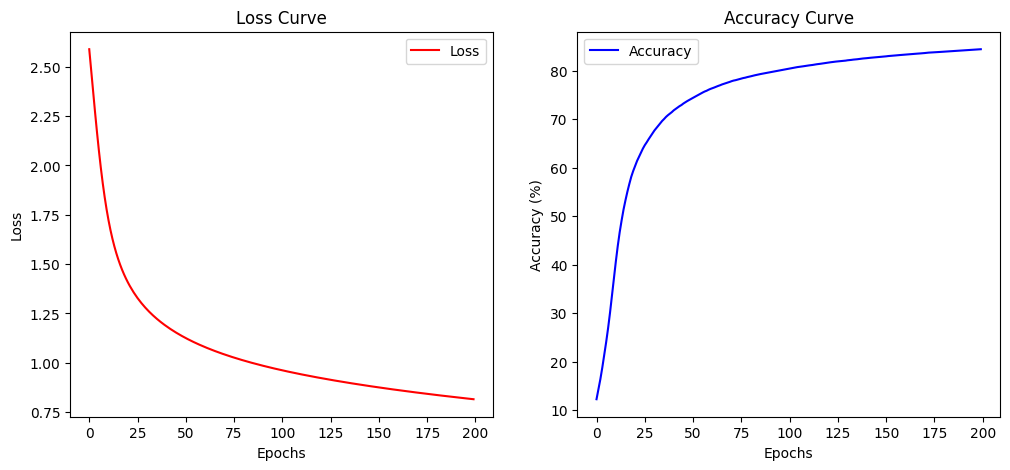

In [10]:
activations = ["sigmoid","sigmoid", "sigmoid", "sigmoid", "softmax"]
parameters, losses, batch_norm_cache, gradient_magnitudes_history = train_neural_network(X_train, y_train, layer_sizes, activations, 200, 0.01)

Test Accuracy: 85.50%

Plotting activation histograms for hidden layers:


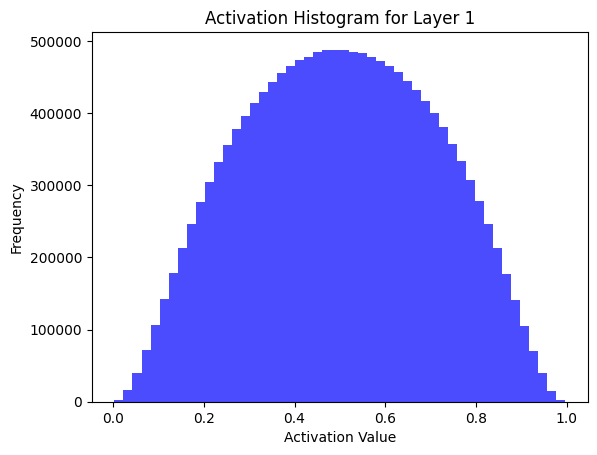

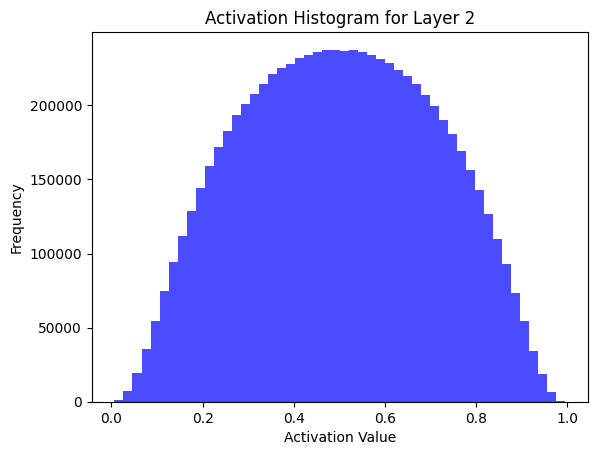

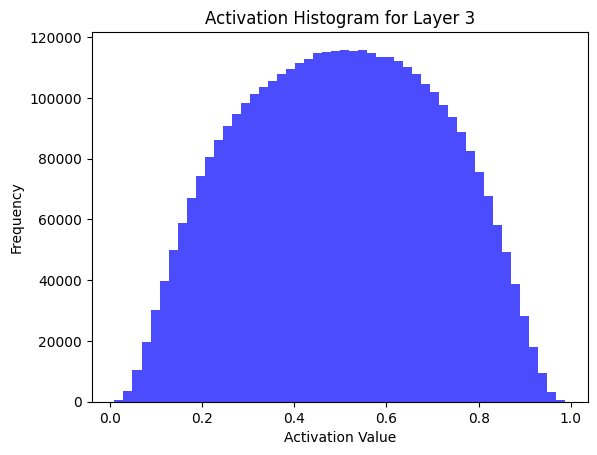

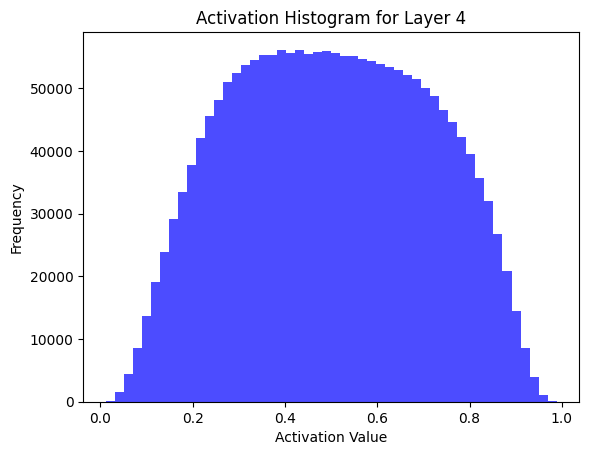

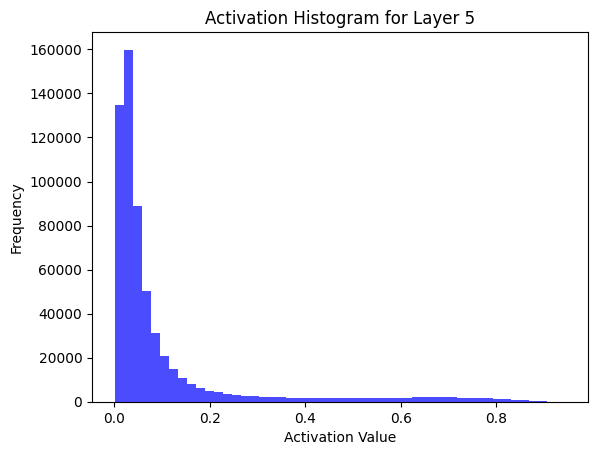

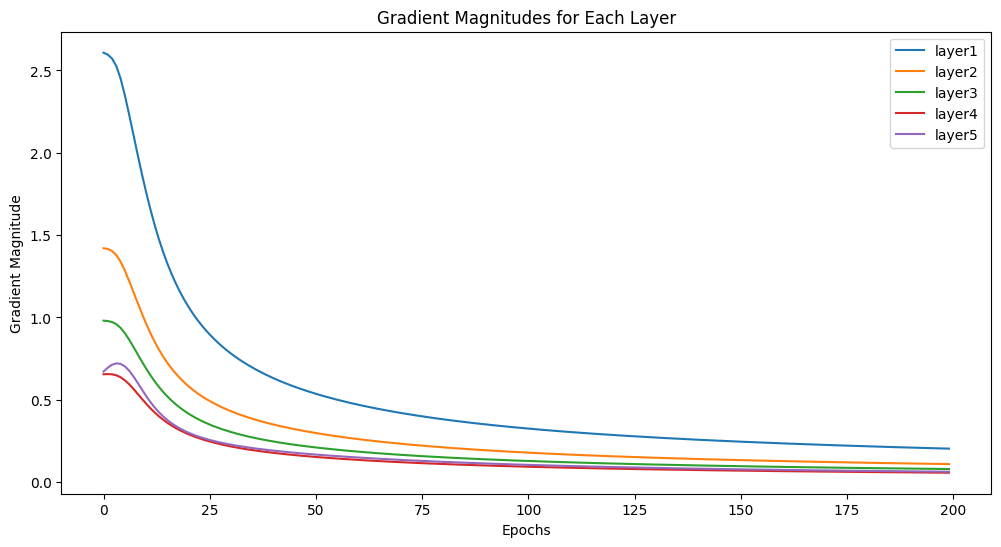

In [12]:
accuracy, A = evaluate_model(X_test, y_test, parameters, activations,batch_norm_cache)

# Plot activation histograms
print("\nPlotting activation histograms for hidden layers:")
_, caches,_ = forward_propagation(X_train, parameters, activations, is_training=False, batch_norm_cache=batch_norm_cache)  # Get latest activations

# Iterate through the caches list
for layer_idx, cache in enumerate(caches):
    # Extract the activation (A) from the cache dictionary
    if isinstance(cache, dict):  # Check if cache is a dictionary
        if "A" in cache:  # Check if "A" is the key for activations
            A = cache["A"]
        else:
            # If the key is different, inspect the cache to find the correct key
            print(f"Cache for layer {layer_idx + 1} does not contain key 'A'. Available keys: {cache.keys()}")
            continue
    else:
        print(f"Cache for layer {layer_idx + 1} is not a dictionary. Type: {type(cache)}")
        continue

    # Flatten the activation to plot the histogram
    A_flat = A.flatten()

    # Plot the histogram
    plt.figure()
    plt.hist(A_flat, bins=50, color='blue', alpha=0.7)
    plt.title(f'Activation Histogram for Layer {layer_idx + 1}')
    plt.xlabel('Activation Value')
    plt.ylabel('Frequency')
    plt.show()

# Plot gradient magnitudes for each layer
plt.figure(figsize=(12, 6))
for layer in gradient_magnitudes_history:
    plt.plot(range(200), gradient_magnitudes_history[layer], label=f"{layer}")
plt.xlabel("Epochs")
plt.ylabel("Gradient Magnitude")
plt.title("Gradient Magnitudes for Each Layer")
plt.legend()
plt.show()

Epoch 0, Loss: 2.6181, Accuracy: 12.42%
Epoch 10, Loss: 2.0561, Accuracy: 28.91%
Epoch 20, Loss: 1.7762, Accuracy: 41.28%
Epoch 30, Loss: 1.6041, Accuracy: 50.13%
Epoch 40, Loss: 1.4822, Accuracy: 56.51%
Epoch 50, Loss: 1.3900, Accuracy: 61.35%
Epoch 60, Loss: 1.3174, Accuracy: 64.97%
Epoch 70, Loss: 1.2578, Accuracy: 67.83%
Epoch 80, Loss: 1.2075, Accuracy: 70.17%
Epoch 90, Loss: 1.1640, Accuracy: 72.00%
Epoch 100, Loss: 1.1256, Accuracy: 73.60%
Epoch 110, Loss: 1.0914, Accuracy: 74.92%
Epoch 120, Loss: 1.0603, Accuracy: 76.12%
Epoch 130, Loss: 1.0319, Accuracy: 77.19%
Epoch 140, Loss: 1.0058, Accuracy: 78.09%
Epoch 150, Loss: 0.9815, Accuracy: 78.94%
Epoch 160, Loss: 0.9588, Accuracy: 79.67%
Epoch 170, Loss: 0.9376, Accuracy: 80.30%
Epoch 180, Loss: 0.9175, Accuracy: 80.88%
Epoch 190, Loss: 0.8985, Accuracy: 81.43%


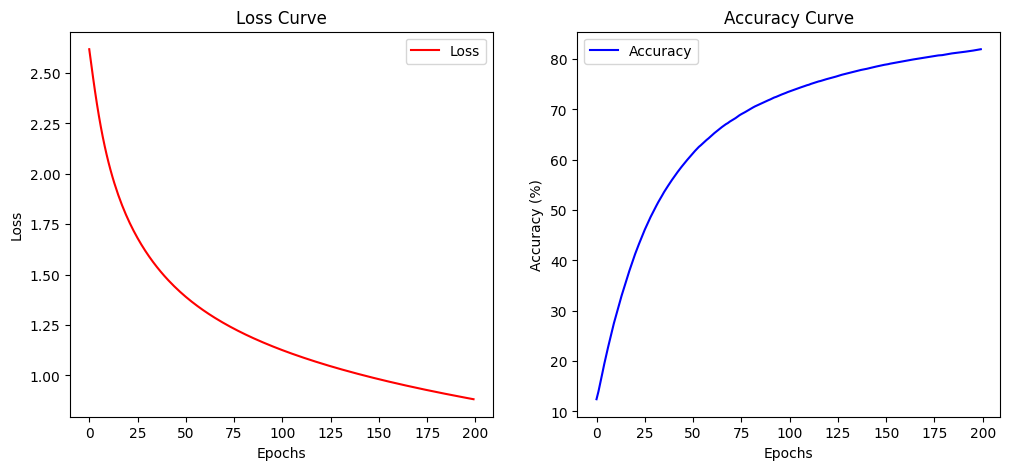

Test Accuracy: 82.88%

Plotting activation histograms for hidden layers:


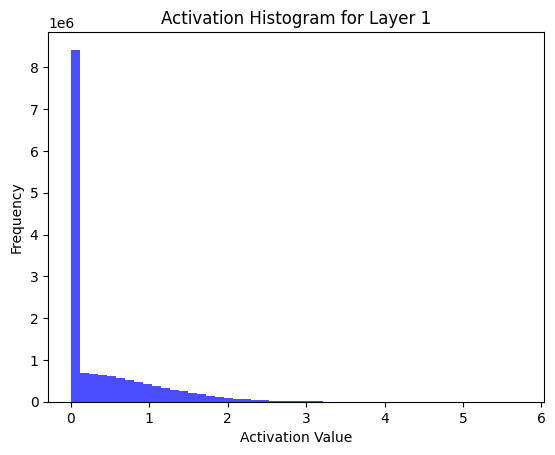

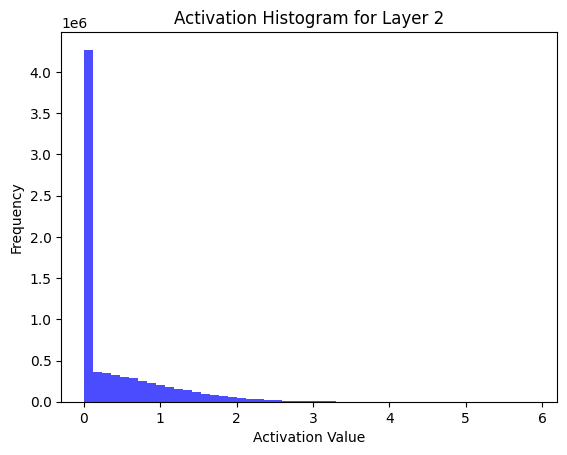

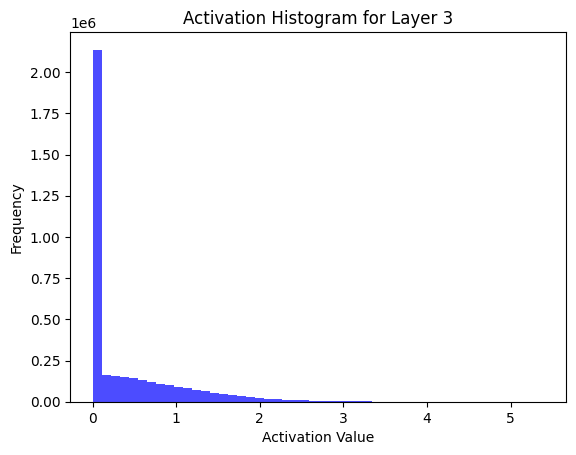

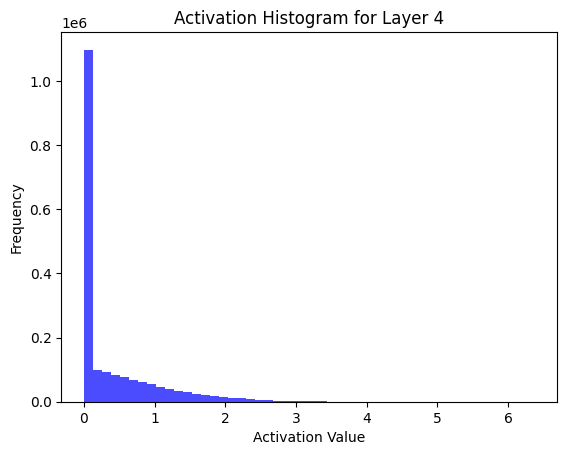

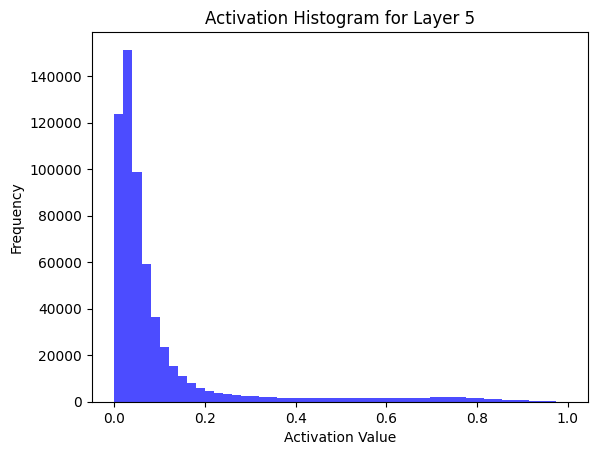

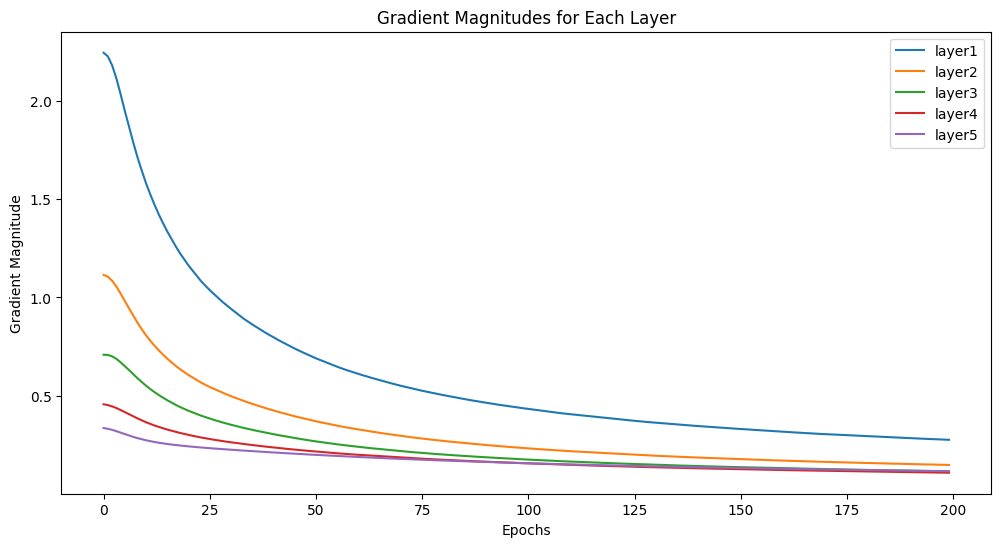

In [11]:
activations_relu = ["relu","relu", "relu", "relu", "softmax"]
parameters_relu, losses_relu, batch_norm_cache_relu, gradient_magnitudes_history_relu = train_neural_network(X_train, y_train, layer_sizes, activations_relu, 200, 0.01)
accuracy_relu, A_relu = evaluate_model(X_test, y_test, parameters_relu, activations_relu, batch_norm_cache_relu)

# Plot activation histogram ReLU
print("\nPlotting activation histograms for hidden layers:")
_, caches, _ = forward_propagation(X_train, parameters_relu, activations_relu, is_training=False, batch_norm_cache=batch_norm_cache_relu)  # Get latest activations

# Iterate through the caches list
for layer_idx, cache in enumerate(caches):
    # Extract the activation (A) from the cache dictionary
    if isinstance(cache, dict):  # Check if cache is a dictionary
        if "A" in cache:  # Check if "A" is the key for activations
            A = cache["A"]
        else:
            # If the key is different, inspect the cache to find the correct key
            print(f"Cache for layer {layer_idx + 1} does not contain key 'A'. Available keys: {cache.keys()}")
            continue
    else:
        print(f"Cache for layer {layer_idx + 1} is not a dictionary. Type: {type(cache)}")
        continue

    # Flatten the activation to plot the histogram
    A_flat = A.flatten()

    # Plot the histogram
    plt.figure()
    plt.hist(A_flat, bins=50, color='blue', alpha=0.7)
    plt.title(f'Activation Histogram for Layer {layer_idx + 1}')
    plt.xlabel('Activation Value')
    plt.ylabel('Frequency')
    plt.show()

# Plot gradient magnitudes for each layer
plt.figure(figsize=(12, 6))
for layer in gradient_magnitudes_history_relu:
    plt.plot(range(200), gradient_magnitudes_history_relu[layer], label=f"{layer}")
plt.xlabel("Epochs")
plt.ylabel("Gradient Magnitude")
plt.title("Gradient Magnitudes for Each Layer")
plt.legend()
plt.show()

Epoch 0, Loss: 2.8755, Accuracy: 7.81%
Epoch 10, Loss: 1.6812, Accuracy: 45.54%
Epoch 20, Loss: 1.4091, Accuracy: 59.40%
Epoch 30, Loss: 1.2790, Accuracy: 66.32%
Epoch 40, Loss: 1.1971, Accuracy: 70.58%
Epoch 50, Loss: 1.1378, Accuracy: 73.44%
Epoch 60, Loss: 1.0912, Accuracy: 75.54%
Epoch 70, Loss: 1.0529, Accuracy: 77.19%
Epoch 80, Loss: 1.0202, Accuracy: 78.53%
Epoch 90, Loss: 0.9917, Accuracy: 79.62%
Epoch 100, Loss: 0.9663, Accuracy: 80.55%
Epoch 110, Loss: 0.9435, Accuracy: 81.28%
Epoch 120, Loss: 0.9226, Accuracy: 81.94%
Epoch 130, Loss: 0.9034, Accuracy: 82.52%
Epoch 140, Loss: 0.8857, Accuracy: 83.02%
Epoch 150, Loss: 0.8691, Accuracy: 83.45%
Epoch 160, Loss: 0.8536, Accuracy: 83.84%
Epoch 170, Loss: 0.8390, Accuracy: 84.14%
Epoch 180, Loss: 0.8252, Accuracy: 84.43%
Epoch 190, Loss: 0.8122, Accuracy: 84.70%


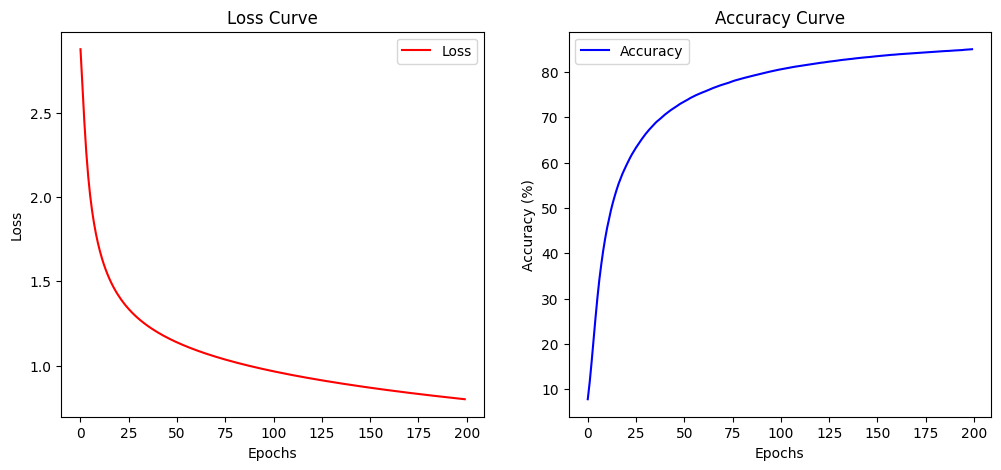

Test Accuracy: 86.07%

Plotting activation histograms for hidden layers:


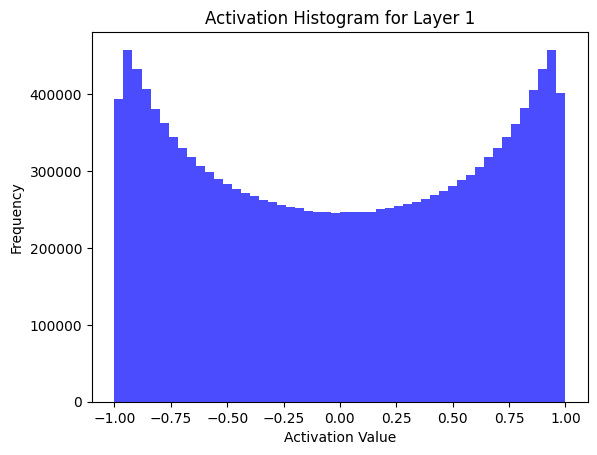

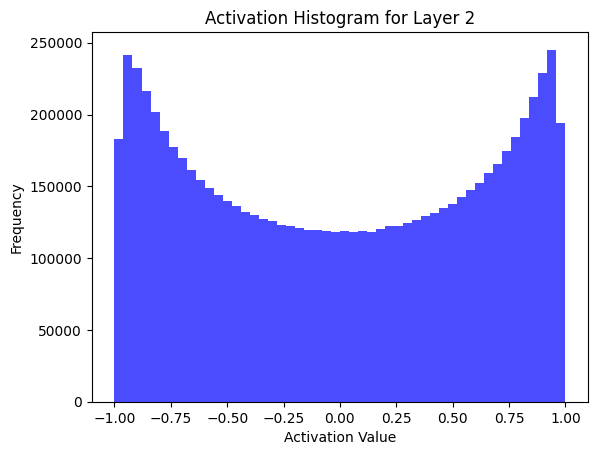

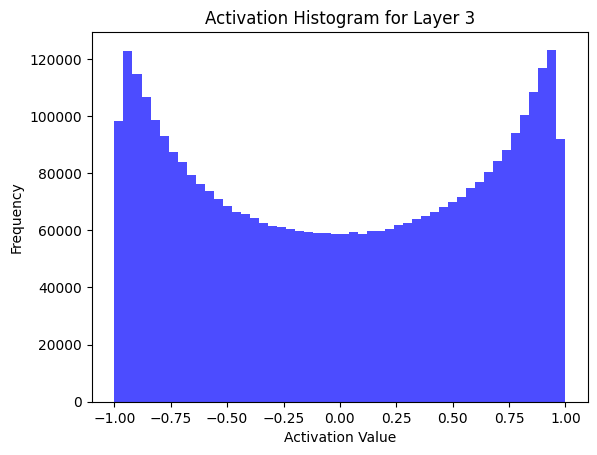

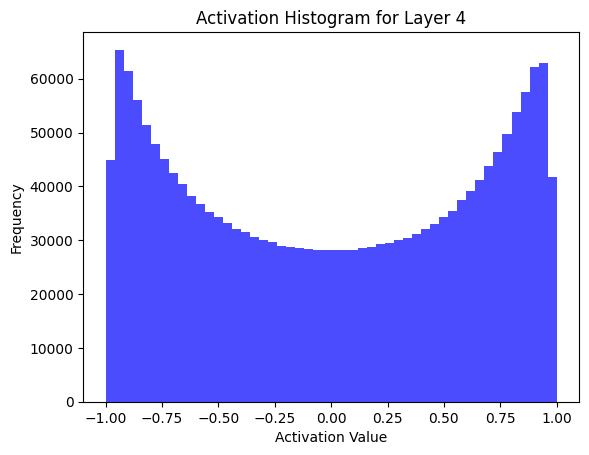

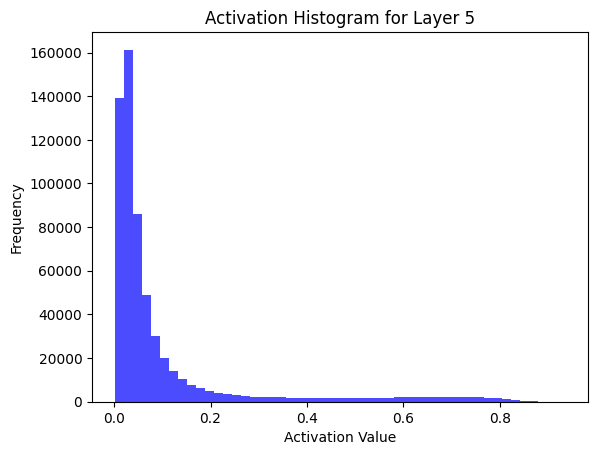

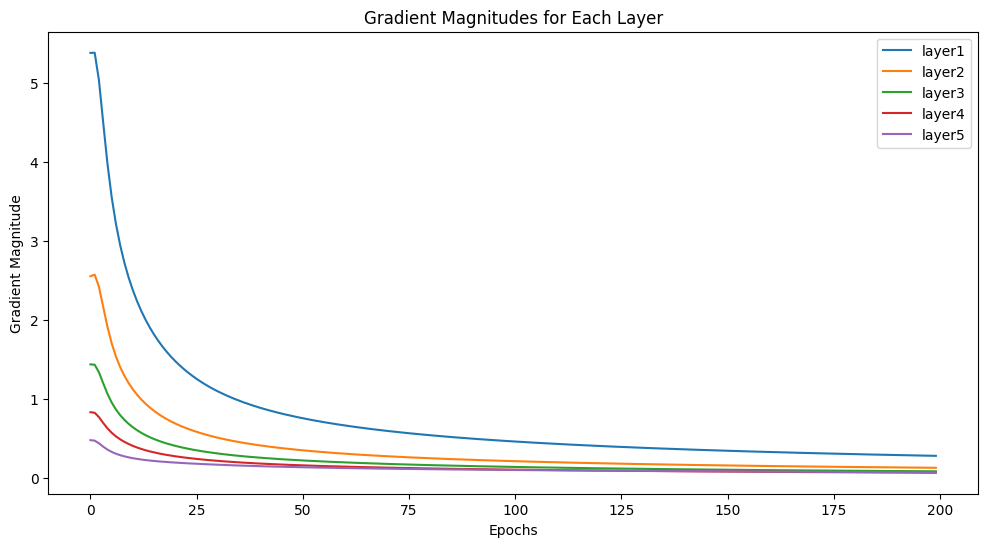

In [7]:
activations_tanh = ["tanh","tanh", "tanh", "tanh", "softmax"]
parameters_tanh, losses_tanh, batch_norm_cache_tanh, gradient_magnitudes_history_tanh = train_neural_network(X_train, y_train, layer_sizes, activations_tanh, 200, 0.01)
accuracy_tanh, A_tanh = evaluate_model(X_test, y_test, parameters_tanh, activations_tanh, batch_norm_cache_tanh)

# Plot activation histograms for
print("\nPlotting activation histograms for hidden layers:")
_, caches,_ = forward_propagation(X_train, parameters_tanh, activations_tanh, is_training=False, batch_norm_cache=batch_norm_cache_tanh)  # Get latest activations

# Iterate through the caches list
for layer_idx, cache in enumerate(caches):
    # Extract the activation (A) from the cache dictionary
    if isinstance(cache, dict):  # Check if cache is a dictionary
        if "A" in cache:  # Check if "A" is the key for activations
            A = cache["A"]
        else:
            # If the key is different, inspect the cache to find the correct key
            print(f"Cache for layer {layer_idx + 1} does not contain key 'A'. Available keys: {cache.keys()}")
            continue
    else:
        print(f"Cache for layer {layer_idx + 1} is not a dictionary. Type: {type(cache)}")
        continue

    # Flatten the activation to plot the histogram
    A_flat = A.flatten()

    # Plot the histogram
    plt.figure()
    plt.hist(A_flat, bins=50, color='blue', alpha=0.7)
    plt.title(f'Activation Histogram for Layer {layer_idx + 1}')
    plt.xlabel('Activation Value')
    plt.ylabel('Frequency')
    plt.show()

# Plot gradient magnitudes for each layer
plt.figure(figsize=(12, 6))
for layer in gradient_magnitudes_history_tanh:
    plt.plot(range(200), gradient_magnitudes_history_tanh[layer], label=f"{layer}")
plt.xlabel("Epochs")
plt.ylabel("Gradient Magnitude")
plt.title("Gradient Magnitudes for Each Layer")
plt.legend()
plt.show()

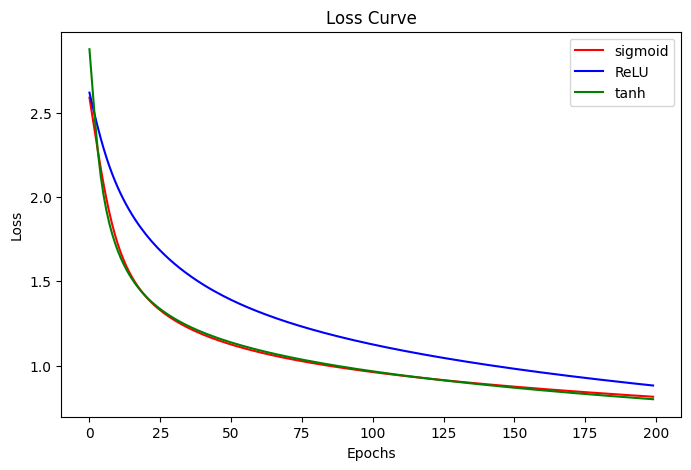

In [13]:
# Loss curves
plt.figure(figsize=(8,5))

plt.plot(range(200), losses, label="sigmoid", color="red")
plt.plot(range(200), losses_relu, label="ReLU", color="blue")
plt.plot(range(200), losses_tanh, label="tanh", color="green")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.show()

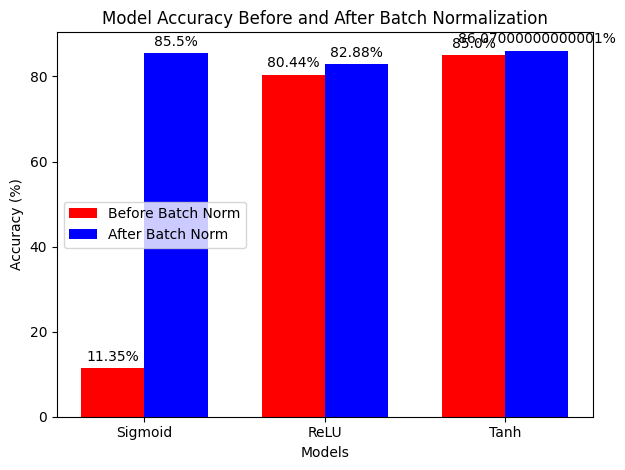

In [16]:
# Accuracy Comparison

# Data
models = ['Sigmoid', 'ReLU', 'Tanh']
accuracy_before = [11.35, 80.44, 85] # values taken from task 1
accuracy_after = [accuracy, accuracy_relu, accuracy_tanh]

# Set up the figure and axis
fig, ax = plt.subplots()

# Bar width
bar_width = 0.35

# Position of bars on x-axis
indices = np.arange(len(models))

# Plotting the bars
bar1 = ax.bar(indices - bar_width/2, accuracy_before, bar_width, label='Before Batch Norm', color='r')
bar2 = ax.bar(indices + bar_width/2, accuracy_after, bar_width, label='After Batch Norm', color='b')

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Model Accuracy Before and After Batch Normalization')
ax.set_xticks(indices)
ax.set_xticklabels(models)
ax.legend()

# Add value labels on top of each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}%',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)

# Show the plot
plt.tight_layout()
plt.show()
